In [1]:
import torch

from tqdm.auto import tqdm

from point_e.diffusion.configs import diffusion_from_config
from point_e.models.configs import model_from_config
from point_e.config import MODEL_CONFIGS,DIFFUSION_CONFIGS

from point_e.utils.download import load_checkpoint
from point_e.diffusion.sampler import PointCloudSampler
from point_e.utils.plotting import plot_point_cloud

/home/aioz-nghiale/anaconda3/envs/point_e_revised/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
guidance_scale = [3.0, 0.0]
num_points=[1024, 4096 - 1024]

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=num_points,
    aux_channels=['R', 'G', 'B'],
    guidance_scale=guidance_scale,
    model_kwargs_key_filter=('images', ''), # Do not condition the upsampler at all
    use_karras = (False,False)
)

In [4]:
pre_noise = []
for (stage_pt,guide_scale) in zip(num_points,guidance_scale):
    batch_size = 1
    sample_shape = (batch_size, 3 + len(sampler.aux_channels), stage_pt)
    internal_batch_size = batch_size
    if guide_scale:
        internal_batch_size *= 2
    pre_noise.append(
        torch.randn(*(internal_batch_size, *sample_shape[1:]))
    )

In [ ]:
from diff_conditioning import OriginDistanceCond

cond_cls = OriginDistanceCond(
    grad_scale=1.e-1,
    calc_gradient=True
)
cond_fn_lst = [cond_cls.calculate_gradient, None]

In [6]:
from PIL import Image
# Set a prompt to condition on.
img = Image.open('asset/helmet.webp')

# Produce a sample from the model.
samples_set = []
final_sample = None
count = 0
for x in tqdm(sampler.sample_batch_progressive(
    batch_size=1, model_kwargs=dict(images=[img]),
    pre_noise=pre_noise,
    cond_fn_lst=cond_fn_lst
)):
    if count%128 == 0: samples_set.append(x)
    final_sample = x
    count+=1

samples_set.append(final_sample)
len(samples_set)

1024it [00:44, 23.29it/s]

done with one


1537it [02:04, 12.35it/s]


KeyboardInterrupt: 

In [ ]:
from point_e.utils.point_cloud import PointCloud
from point_e.utils.path import LOG_DIR
import os

SAMPLE_NAME = 'helmet_grad_scale_1e-1'

pc_set = [sampler.output_to_point_clouds(sample)[0] for sample in samples_set]

PointCloud.write_batch_ply(pc_set,SAMPLE_NAME)

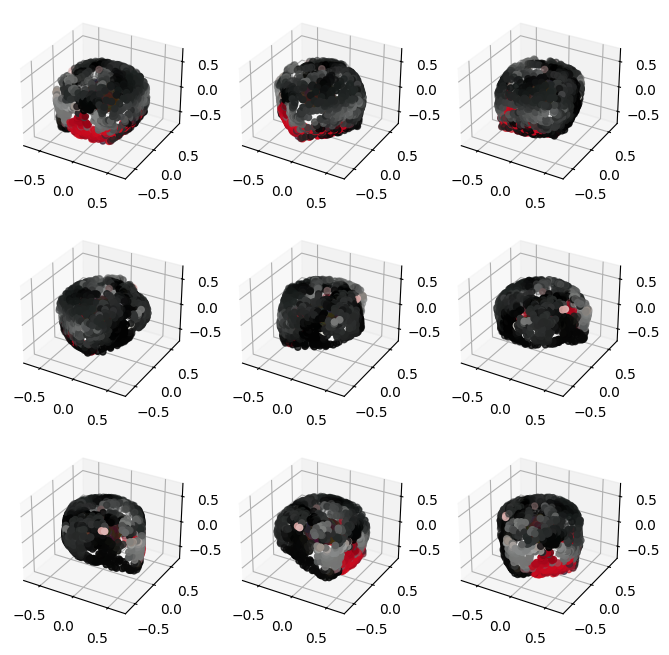

In [ ]:
pc = sampler.output_to_point_clouds(samples_set[9])[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
sum([grad_tens.mean() for grad_tens in cond_cls.grad_lst])/len(cond_cls.grad_lst), sum([grad_tens.mean() for grad_tens in cond_cls.loss_lst])/len(cond_cls.loss_lst)

(tensor(0., device='cuda:0'),
 tensor(425710.4062, device='cuda:0', grad_fn=<DivBackward0>))

In [ ]:
grad_mean = torch.stack([grad_tens.mean() for grad_tens in cond_cls.grad_lst],dim = 0).tolist()
loss_mean = torch.stack([loss_tens.mean() for loss_tens in cond_cls.loss_lst],dim = 0).tolist()

with open(f'log_{SAMPLE_NAME}.txt','w') as f:
    print({
        "grad_mean":grad_mean,
        "loss_mean":loss_mean
    },file=f)